# Validation

In [1]:
import os
import datetime
import itertools
import numpy as np
import pandas as pd
from functools import reduce
from tqdm import tqdm
from pandas import DataFrame

from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
import pingouin as pg

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# !gsutil cp -r gs://master-thesis-data/logs/cookpad_naive_results.csv ../data/results/cookpad_concat_results.csv
# !gsutil cp -r gs://master-thesis-data/logs/cookpad_nrmf_simple_query_results.csv ../data/results/cookpad_nrmf_results.csv
# !gsutil cp -r gs://master-thesis-data/logs/cookpad_nrmf_simple_query_results.csv ../data/results/cookpad_nrmf_results.csv
# !gsutil cp -r gs://master-thesis-data/logs/cookpad_nrmf_simple_all_results.csv ../data/results/cookpad_nrmf_all_results.csv
# !gsutil cp -r gs://master-thesis-data/logs/cookpad_fwfm_all_results.csv ../data/results/cookpad_fwfm_all_results.csv
# !gsutil cp -r gs://master-thesis-data/logs/cookpad_fwfm_query_results.csv ../data/results/cookpad_fwfm_results.csv
# !gsutil cp -r gs://master-thesis-data/logs/cookpad_nrmf_simple_query_with_1st_results.csv ../data/results/cookpad_nrmf_with_1st_results.csv
# !gsutil cp -r gs://master-thesis-data/logs/cookpad_fwfm_all_without_1st_results.csv ../data/results/cookpad_fwfm_without_1st_results.csv
# !gsutil cp -r gs://master-thesis-data/logs/fwfm_selected_results.csv ../data/results/cookpad_fwfm_selected_results.csv

/Users/kentaro-takiguchi/workspace/field-interactions-in-document-ranking/.venv/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.8, the latest is 0.3.10.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [3]:
results_dir = '../data/results'
dataset = 'cookpad'

def read_csv(model_name):
    return pd.read_csv(
        f'{results_dir}/{dataset}_{model_name}_results.csv',
        usecols=['model', 'ndcg']
    )

dfs = []
for model_name, display_name in zip(
    ['concat', 'nrmf', 'nrmf_all', 'fwfm', 'fwfm_all', 'nrmf_with_1st', 'fwfm_without_1st', 'fwfm_selected'],
    ['Concat', 'NRM-F (query-field)', 'NRM-F (all)', 'FwFM (query-field)', 'FwFM (all)', 'NRM-F (1st + 2nd)', 'FwFM (2nd)', 'FwFM (selected)'],
):
    df = read_csv(model_name)
    df.rename(columns={'ndcg': display_name}, inplace=True)
    df.drop(columns=['model'], inplace=True)
    dfs.append(df)

df = pd.concat(dfs, axis=1)
df

,Concat,NRM-F (query-field),NRM-F (all),FwFM (query-field),FwFM (all),NRM-F (1st + 2nd),FwFM (2nd),FwFM (selected)
0,0.6414,0.6535,0.6443,0.6730,0.6665,0.6541,0.6521,0.6757
1,0.6349,0.6741,0.6456,0.6778,0.6667,0.6674,0.6541,0.6718
2,0.6536,0.6692,0.6485,0.6684,0.6679,0.6526,0.6532,0.6703
3,0.6459,0.6556,0.6417,0.6677,0.6668,0.6548,0.6498,0.6596
4,0.6465,0.6460,0.6368,0.6633,0.6556,0.6381,0.6378,0.6590
5,0.6348,0.6401,0.6383,0.6594,0.6538,0.6435,0.6238,0.6537
6,0.6408,0.6356,0.6312,0.6514,0.6480,0.6415,0.6398,0.6469
7,0.6422,0.6487,0.6423,0.6665,0.6573,0.6474,0.6437,0.6594
8,0.6463,0.6466,0.6370,0.6683,0.6663,0.6523,0.6483,0.6668
9,0.6475,0.6484,0.6415,0.6698,0.6570,0.6454,0.6442,0.6676


In [4]:
temp = round(df.mean(), 3).reset_index(name='ndcg')
temp.rename(columns={'index': 'model'}, inplace=True)
temp.sort_values(by='ndcg', ascending=False)

,model,ndcg
3,FwFM (query-field),0.667
7,FwFM (selected),0.663
4,FwFM (all),0.661
1,NRM-F (query-field),0.652
5,NRM-F (1st + 2nd),0.650
6,FwFM (2nd),0.645
0,Concat,0.643
2,NRM-F (all),0.641


In [5]:
def boxplot(df, model_names, column_names=None):
    if column_names:
        df = df.rename(columns={m: c for m, c in zip(model_names, column_names)})
        model_names = column_names
    
    df.boxplot(column=model_names, grid=False, rot=45)
    plt.show()

def validate(df, model_names, column_names=None):
    if column_names:
        df = df.rename(columns={m: c for m, c in zip(model_names, column_names)})
        model_names = column_names
    
    melted_df = pd.melt(df.reset_index(), id_vars=['index'], value_vars=model_names)
    melted_df.columns = ['index', 'treatments', 'value']
    
    posthoc = pg.pairwise_ttests(
        data=melted_df,
        dv='value',
        between='treatments',
        parametric=True,
        padjust='bonf',
        effsize='cohen',
    )
    pd.options.display.float_format = '{:,.3f}'.format
    display(pd.DataFrame(posthoc))

## Experiment 1

Query-to-field vs Field-to-field Interactions

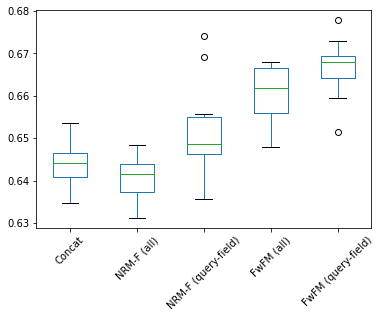

,Contrast,A,B,Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,cohen
0,treatments,Concat,NRM-F (all),False,True,1.100,18.000,two-sided,0.286,1.000,bonf,0.605,0.492
1,treatments,Concat,NRM-F (query-field),False,True,-1.989,18.000,two-sided,0.062,0.622,bonf,1.476,-0.889
2,treatments,Concat,FwFM (all),False,True,-5.944,18.000,two-sided,0.000,0.000,bonf,1154.188,-2.658
3,treatments,Concat,FwFM (query-field),False,True,-7.864,18.000,two-sided,0.000,0.000,bonf,3.046e+04,-3.517
4,treatments,NRM-F (all),NRM-F (query-field),False,True,-2.686,18.000,two-sided,0.015,0.151,bonf,3.862,-1.201
5,treatments,NRM-F (all),FwFM (all),False,True,-7.245,18.000,two-sided,0.000,0.000,bonf,1.099e+04,-3.240
6,treatments,NRM-F (all),FwFM (query-field),False,True,-9.235,18.000,two-sided,0.000,0.000,bonf,2.544e+05,-4.130
7,treatments,NRM-F (query-field),FwFM (all),False,True,-1.999,18.000,two-sided,0.061,0.610,bonf,1.495,-0.894
8,treatments,NRM-F (query-field),FwFM (query-field),False,True,-3.327,18.000,two-sided,0.004,0.038,bonf,10.743,-1.488
9,treatments,FwFM (all),FwFM (query-field),False,True,-1.859,18.000,two-sided,0.079,0.794,bonf,1.264,-0.832


In [6]:
boxplot(df,
        ['Concat', 'NRM-F (all)', 'NRM-F (query-field)', 'FwFM (all)', 'FwFM (query-field)'],
       )
validate(df,
        ['Concat', 'NRM-F (all)', 'NRM-F (query-field)', 'FwFM (all)', 'FwFM (query-field)']
       )

## Experiment 2

Importance of Interactions beyond Query-Fields

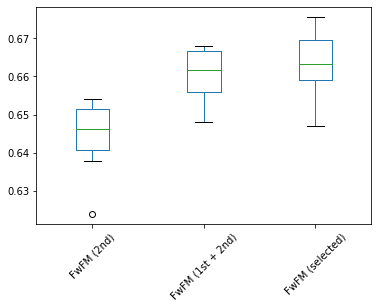

,Contrast,A,B,Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,cohen
0,treatments,FwFM (2nd),FwFM (1st + 2nd),False,True,-4.332,18.000,two-sided,0.000,0.001,bonf,62.458,-1.937
1,treatments,FwFM (2nd),FwFM (selected),False,True,-4.541,18.000,two-sided,0.000,0.001,bonf,91.156,-2.031
2,treatments,FwFM (1st + 2nd),FwFM (selected),False,True,-0.692,18.000,two-sided,0.498,1.000,bonf,0.471,-0.310


In [7]:
boxplot(df,
         ['FwFM (2nd)', 'FwFM (all)', 'FwFM (selected)'],
         ['FwFM (2nd)', 'FwFM (1st + 2nd)', 'FwFM (selected)']
        )
validate(df,
         ['FwFM (2nd)', 'FwFM (all)', 'FwFM (selected)'],
         ['FwFM (2nd)', 'FwFM (1st + 2nd)', 'FwFM (selected)']
        )

## Experiment 3

Non-Linear Field Interactions

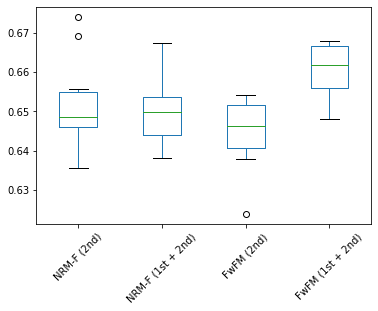

,Contrast,A,B,Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,cohen
0,treatments,NRM-F (2nd),NRM-F (1st + 2nd),False,True,0.446,18.000,two-sided,0.661,1.000,bonf,0.426,0.200
1,treatments,NRM-F (2nd),FwFM (2nd),False,True,1.483,18.000,two-sided,0.155,0.932,bonf,0.843,0.663
2,treatments,NRM-F (2nd),FwFM (1st + 2nd),False,True,-1.999,18.000,two-sided,0.061,0.366,bonf,1.495,-0.894
3,treatments,NRM-F (1st + 2nd),FwFM (2nd),False,True,1.274,18.000,two-sided,0.219,1.000,bonf,0.697,0.570
4,treatments,NRM-F (1st + 2nd),FwFM (1st + 2nd),False,True,-3.129,18.000,two-sided,0.006,0.035,bonf,7.748,-1.399
5,treatments,FwFM (2nd),FwFM (1st + 2nd),False,True,-4.332,18.000,two-sided,0.000,0.002,bonf,62.458,-1.937


In [8]:
boxplot(df,
         ['NRM-F (query-field)', 'NRM-F (1st + 2nd)', 'FwFM (2nd)', 'FwFM (all)'],
         ['NRM-F (2nd)', 'NRM-F (1st + 2nd)', 'FwFM (2nd)', 'FwFM (1st + 2nd)']
        )
validate(df,
         ['NRM-F (query-field)', 'NRM-F (1st + 2nd)', 'FwFM (2nd)', 'FwFM (all)'],
         ['NRM-F (2nd)', 'NRM-F (1st + 2nd)', 'FwFM (2nd)', 'FwFM (1st + 2nd)']
        )